## Develop a Neural Bag-of-Words Model for Sentiment Analysis.

#### 1. Movie Review Dataset

We will be using the process and dataset as described in this notebook: http://localhost:8888/notebooks/Documents/Programming%23/AMMI%20Basics/Natural%20Language%20Processing%20Keras/4.%20Sentiment%20Analysis%20Data%20Preparation..ipynb.

Note, all processes in the above link can be run from the terminal using the main.py script. Though one may have to download the file manually and run the process of unzipping and extracting the file. We'll fix this in the script later.

#### 2. Data Preparation

#### 2.1. Split data into training and testing sets.

We'll split the data into 90% for train and 10% for test. We can do this without shuffling the data as there is no time factor in the collection of our data.

#### 2.2. Loading and cleaning data to remove punctuation and numbers.

Luckily we already have functions designed to clean our data, we can load them and use to:
    
    1. Split tokens on whitespace.
    2. Remove all punctuation from words.
    3. Remove all words that are not purely comprised of alphabetical characters.
    4. Remove all words that are known stop words.
    5. Remove all words that have a length <= 1

In [1]:
# Reuse our saved modules.
from text_prep import *
from save_processed import *

Using TensorFlow backend.


In [2]:
%whos

Variable            Type                Data/Info
-------------------------------------------------
Tokenizer           type                <class 'keras_preprocessing.text.Tokenizer'>
add_doc_to_vocab    function            <function add_doc_to_vocab at 0x7f4a497029d8>
clean_doc           function            <function clean_doc at 0x7f4abce541e0>
create_tokenizer    function            <function create_tokenizer at 0x7f4a49702bf8>
doc_to_line         function            <function doc_to_line at 0x7f4a49702c80>
load_doc            function            <function load_doc at 0x7f4abce34f28>
os                  module              <module 'os' from '/usr/lib/python3.7/os.py'>
process_docs        function            <function process_docs at 0x7f4a49702a60>
process_docs_full   function            <function process_docs_full at 0x7f4a49702d08>
re                  module              <module 're' from '/usr/lib/python3.7/re.py'>
remove_min          function            <function remove_min at 

In [3]:
# load the document
filename = 'Data/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

#### 2.3. Defining a vocabulary of preferred words.

In [3]:
# Load the counter module to create a vocabulary of all documents
from collections import Counter
# Define vocab
vocab = Counter()
# Add all docs to vocab using our process_docs() function
process_docs('Data/txt_sentoken/pos', vocab)
process_docs('Data/txt_sentoken/neg', vocab)
# print size of vocab
print(len(vocab))

44276


**Note** we created our vocabulary from our train set not the train and test.

In [4]:
# Remove minimum occurences using the remove_min() function
tokens = remove_min(2, vocab)
print(len(tokens))

25767


In [5]:
# Finally lets save this new vocab to later use it using our save_list() function
save_list(tokens, 'Data/vocab_25767.txt')

Done saving vocabulary to Data/vocab_25767.txt ...


#### 3. Bag-of-Words Representation

What we need now is a way of representing our data so we can provide it to a multilayer perceptron model. BOW is a way of extracting features from text so the text input can be used with Machine learning algorithms like neural networks.

Words in a document are scored and the scores are placed in the corresponding locations in the representation.

3.1. Convert reviews to lines of tokens.

In [6]:
# We'll use our doc_to_line() function.
# then we'll walkthrough all the files we have in our directory and encode each into our vocab using the process_docs_full() function

def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs_full('Data/txt_sentoken/neg', vocab, is_train)
    pos = process_docs_full('Data/txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    
    # Prepare the labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

In [7]:
# Now let's load our vocabulary we had created and saved.
vocab_filename = 'Data/vocab_25767.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [9]:
# Finally we can load all our training reviews
document, labels = load_clean_dataset(vocab, True)
# Summarize what we have
print(len(document), len(labels))

1800 1800


In [10]:
# Load our testing reviews.
test_document, test_labels = load_clean_dataset(vocab, False)
# Summarize what we have
print(len(test_document), len(test_labels))

200 200


3.2. Encode reviews with a bag-of-words model representation.

We will use the Keras API to convert reviews to encoded document vectors. The tokenizer class is convenient and will easily transform documents into encoded vectors. First, the tokenizer must be created, then fit on the text documents in the training dataset. Inthis case, these are the aggregation of the positive_lines and negative_lines arrays developed in the previous section.

In [24]:
# Load tokenizer module
from keras.preprocessing.text import Tokenizer
# Create a tokenizer function (Already created in scripts)

In [11]:
# Putting it all together.
# Load vocab created from the words (Loaded above)
# Load all reviews
train_docs, y_train = load_clean_dataset(vocab, True)
test_docs, y_test = load_clean_dataset(vocab, False)
# Create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [12]:
# Encode data
X_train = tokenizer.texts_to_matrix(train_docs, mode='freq') # You can change the mode to any other.
X_test = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(X_train.shape, X_test.shape)

(1800, 25768) (200, 25768)


#### 4. Sentiment Analysis Models

Now we have our train and test data with the same sized encoding vocabulary (vector length), we can develop a Multilayer Perceptron model to classify encoded documents as wither positive or negative.

Our MLP should have an input layer that equals the number of words in the vocabulary, and in turn the length of the input documents.

In [14]:
# Get the number of words. note this is same for the test set too.
n_words = X_train.shape[1]

In [16]:
# Imports for the model
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

In [36]:
# Define the model
def sen_model1(n_words):
    # Define network
    input_layer = Input(shape = (n_words,))
    hidden1 = Dense(50, activation='relu')(input_layer)
    output = Dense(1, activation='sigmoid')(hidden1)
    model = Model(inputs = input_layer, outputs = output)
    # Get model summary    
    # model.summary()
    # Plot the model
    # plot_model(model, to_file='Model_Images/sent_model1.png', show_shapes=True)
    return model

In [20]:
model = sen_model1(n_words)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
model.compile('adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# fit the network
model.fit(X_train, y_train, epochs=10, verbose = 2)

Epoch 1/10
 - 1s - loss: 0.6917 - accuracy: 0.6017
Epoch 2/10
 - 1s - loss: 0.6832 - accuracy: 0.8389
Epoch 3/10
 - 1s - loss: 0.6670 - accuracy: 0.8800
Epoch 4/10
 - 1s - loss: 0.6418 - accuracy: 0.8800
Epoch 5/10
 - 1s - loss: 0.6092 - accuracy: 0.9178
Epoch 6/10
 - 1s - loss: 0.5692 - accuracy: 0.9422
Epoch 7/10
 - 1s - loss: 0.5266 - accuracy: 0.9456
Epoch 8/10
 - 1s - loss: 0.4833 - accuracy: 0.9500
Epoch 9/10
 - 1s - loss: 0.4400 - accuracy: 0.9556
Epoch 10/10
 - 1s - loss: 0.3991 - accuracy: 0.9628


In [23]:
# Evaluate network
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f'% (acc*100))

Test Accuracy: 87.000000


#### 5. Comparing Word Scoring Methods

We can see the above scores are pretty much alright for the dataset we are working with and reflect the paper and text-book for the BOW model.

The texts_to_matrix() function in Tokenizer in the Keras API provides 4 different methods for scoring words:
    
    1. binary: where words are marked as present (1) or absent (0).
    2. count: where the occurence count for each word is marked as an integer.
    3. tfidf: where each word is scored based on their frequency, where words that are common across all documents are penalized.
    4. freq: where words are scored based on their frequency of occurence within the document.

Because neural network models are stochastic, we will get various results if we run our model several times. This is good practive as we want to get an average accuracy for our models when building. We'll define a function to allow us make multiple runs on a given network.

In [24]:
# Evaluate network
def evaluate_mode(trainX, trainY, testX, testY):
    scores = list()
    n_repeats = 10
    n_words = trainX.shape[1]
    for i in range(n_repeats):
        #call our model
        model = sen_model1(n_words)
        # compile it
        model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        # fit the model
        model.fit(trainX, trainY, epochs=10, verbose=2)
        # evaluate
        loss, acc = model.evaluate(testX, testY, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s'% ((i+1), acc))
    return scores

In [26]:
scores = evaluate_mode(X_train, y_train, X_test, y_test)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 25768)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 1s - loss: 0.6921 - accuracy: 0.5389
Epoch 2/10
 - 1s - loss: 0.6850 - accuracy: 0.8806
Epoch 3/10
 - 1s - loss: 0.6702 - accuracy: 0.9050
Epoch 4/10
 - 1s - loss: 0.6448 - accuracy: 0.8667
Epoch 5/10
 - 1s - loss: 0.6096 - accuracy: 0.9333
Epoch 6/10
 - 1s - loss: 0.5685 - accuracy: 0.9417
Epoch 7/10
 - 1s - loss: 0.5234 - accuracy: 0.9467
Epoch 8/10
 - 1s - lo

Epoch 1/10
 - 1s - loss: 0.6915 - accuracy: 0.6067
Epoch 2/10
 - 1s - loss: 0.6811 - accuracy: 0.7122
Epoch 3/10
 - 1s - loss: 0.6620 - accuracy: 0.8867
Epoch 4/10
 - 1s - loss: 0.6339 - accuracy: 0.9033
Epoch 5/10
 - 1s - loss: 0.5980 - accuracy: 0.9311
Epoch 6/10
 - 1s - loss: 0.5565 - accuracy: 0.9378
Epoch 7/10
 - 1s - loss: 0.5127 - accuracy: 0.9456
Epoch 8/10
 - 1s - loss: 0.4679 - accuracy: 0.9556
Epoch 9/10
 - 1s - loss: 0.4245 - accuracy: 0.9594
Epoch 10/10
 - 1s - loss: 0.3845 - accuracy: 0.9622
7 accuracy: 0.8600000143051147
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 25768)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_38 (Dense)             (None, 1)      

In [28]:
scores

[0.8650000095367432,
 0.8700000047683716,
 0.8899999856948853,
 0.8700000047683716,
 0.8650000095367432,
 0.8650000095367432,
 0.8600000143051147,
 0.8650000095367432,
 0.8700000047683716,
 0.8650000095367432]

In [33]:
# get the average accuracy
print('Average Accuracy: %.2f%%'% (sum(scores)*100/len(scores)))

Average Accuracy: 86.85%


In [34]:
# Get the maximum and minimum accuracy.
print('Maximum accuracy: %.2f%%, Minimum accuracy: %.2f%%'% (max(scores)*100, min(scores)*100))

Maximum accuracy: 89.00%, Minimum accuracy: 86.00%


**Next:** We need to try out various modes for our BOW model on our multi-run neural network to test how well each mode and model works.

**Before we loose track of our steps, lets put it all together in one big script**

In [35]:
# First let's define a data_prep function for the tokenizer modes.
# Prepare bag of words encoding of docs
def prepare_bow(train_doc, test_doc, mode):
    # Call the create_tokenizer function and fit on train docs
    tokenizer = create_tokenizer(train_doc)
    # Encode the train data
    X_train = tokenizer.texts_to_matrix(train_doc, mode=mode)
    # Encode the test data
    X_test = tokenizer.texts_to_matrix(test_doc, mode=mode)
    return X_train, X_test

In [39]:
# Step 1: Load modules from all locations
from text_prep import * # All our text prep functions
from save_processed import * # all our save routines.
# Supporting modules
from keras.layers import Input, Dense
from keras.models import Model
from pandas import DataFrame
from matplotlib import pyplot

# Load the vocabulary
vocab_filename = 'Data/vocab_25767.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# Load all reviews
train_doc, y_train = load_clean_dataset(vocab, True)
test_doc, y_test = load_clean_dataset(vocab, False)

# Run experiment on all modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    print('For %s mode, training...'%(mode))
    # Prepare data for mode
    X_train, X_test = prepare_bow(train_doc, test_doc, mode)
    # Evaluate model on data for mode
    results[mode] = evaluate_mode(X_train, y_train, X_test, y_test)
# Summarize results
print(results.describe())

For binary mode, training...
Epoch 1/10
 - 1s - loss: 0.4502 - accuracy: 0.7872
Epoch 2/10
 - 1s - loss: 0.0478 - accuracy: 0.9950
Epoch 3/10
 - 1s - loss: 0.0147 - accuracy: 1.0000
Epoch 4/10
 - 1s - loss: 0.0078 - accuracy: 1.0000
Epoch 5/10
 - 1s - loss: 0.0048 - accuracy: 1.0000
Epoch 6/10
 - 1s - loss: 0.0030 - accuracy: 1.0000
Epoch 7/10
 - 2s - loss: 0.0020 - accuracy: 1.0000
Epoch 8/10
 - 1s - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
 - 1s - loss: 0.0010 - accuracy: 1.0000
Epoch 10/10
 - 1s - loss: 8.0031e-04 - accuracy: 1.0000
1 accuracy: 0.9300000071525574
Epoch 1/10
 - 1s - loss: 0.4992 - accuracy: 0.7361
Epoch 2/10
 - 1s - loss: 0.0633 - accuracy: 0.9933
Epoch 3/10
 - 1s - loss: 0.0155 - accuracy: 1.0000
Epoch 4/10
 - 1s - loss: 0.0070 - accuracy: 1.0000
Epoch 5/10
 - 1s - loss: 0.0040 - accuracy: 1.0000
Epoch 6/10
 - 1s - loss: 0.0025 - accuracy: 1.0000
Epoch 7/10
 - 1s - loss: 0.0017 - accuracy: 1.0000
Epoch 8/10
 - 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 9/10
 - 1s 

Epoch 10/10
 - 2s - loss: 9.1354e-04 - accuracy: 1.0000
5 accuracy: 0.8949999809265137
Epoch 1/10
 - 1s - loss: 0.4545 - accuracy: 0.7856
Epoch 2/10
 - 2s - loss: 0.0614 - accuracy: 0.9861
Epoch 3/10
 - 1s - loss: 0.0137 - accuracy: 1.0000
Epoch 4/10
 - 2s - loss: 0.0066 - accuracy: 1.0000
Epoch 5/10
 - 2s - loss: 0.0041 - accuracy: 1.0000
Epoch 6/10
 - 1s - loss: 0.0028 - accuracy: 1.0000
Epoch 7/10
 - 2s - loss: 0.0020 - accuracy: 1.0000
Epoch 8/10
 - 1s - loss: 0.0015 - accuracy: 1.0000
Epoch 9/10
 - 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 10/10
 - 1s - loss: 9.5503e-04 - accuracy: 1.0000
6 accuracy: 0.9100000262260437
Epoch 1/10
 - 2s - loss: 0.4537 - accuracy: 0.7689
Epoch 2/10
 - 2s - loss: 0.0468 - accuracy: 0.9933
Epoch 3/10
 - 1s - loss: 0.0131 - accuracy: 1.0000
Epoch 4/10
 - 1s - loss: 0.0060 - accuracy: 1.0000
Epoch 5/10
 - 1s - loss: 0.0034 - accuracy: 1.0000
Epoch 6/10
 - 1s - loss: 0.0022 - accuracy: 1.0000
Epoch 7/10
 - 1s - loss: 0.0015 - accuracy: 1.0000
Epoch 8/10

 - 2s - loss: 7.5056e-04 - accuracy: 1.0000
Epoch 7/10
 - 1s - loss: 5.2937e-04 - accuracy: 1.0000
Epoch 8/10
 - 1s - loss: 3.9853e-04 - accuracy: 1.0000
Epoch 9/10
 - 1s - loss: 3.0660e-04 - accuracy: 1.0000
Epoch 10/10
 - 1s - loss: 2.4440e-04 - accuracy: 1.0000
10 accuracy: 0.8849999904632568
For freq mode, training...
Epoch 1/10
 - 1s - loss: 0.6921 - accuracy: 0.6133
Epoch 2/10
 - 1s - loss: 0.6857 - accuracy: 0.8767
Epoch 3/10
 - 2s - loss: 0.6732 - accuracy: 0.9028
Epoch 4/10
 - 1s - loss: 0.6546 - accuracy: 0.8783
Epoch 5/10
 - 1s - loss: 0.6274 - accuracy: 0.9294
Epoch 6/10
 - 2s - loss: 0.5978 - accuracy: 0.9378
Epoch 7/10
 - 1s - loss: 0.5633 - accuracy: 0.9461
Epoch 8/10
 - 1s - loss: 0.5272 - accuracy: 0.9461
Epoch 9/10
 - 1s - loss: 0.4911 - accuracy: 0.9517
Epoch 10/10
 - 1s - loss: 0.4557 - accuracy: 0.9544
1 accuracy: 0.8650000095367432
Epoch 1/10
 - 1s - loss: 0.6916 - accuracy: 0.6456
Epoch 2/10
 - 1s - loss: 0.6826 - accuracy: 0.6244
Epoch 3/10
 - 1s - loss: 0.6655 

In [40]:
# Get the evaluation accuracies for the various modes.
results.describe()

,binary,count,tfidf,freq
count,10.000000,10.000000,10.000000,10.000000
mean,0.926500,0.904000,0.878000,0.868500
std,0.008515,0.011255,0.013375,0.004743
min,0.905000,0.880000,0.845000,0.860000
25%,0.925000,0.897500,0.872500,0.865000
50%,0.927500,0.905000,0.885000,0.870000
75%,0.930000,0.913750,0.885000,0.870000
max,0.935000,0.915000,0.890000,0.875000


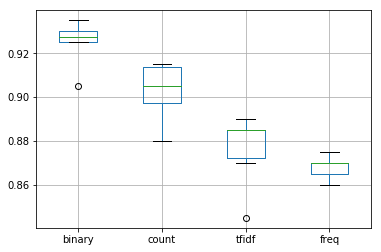

In [41]:
# Show the plot of results
results.boxplot()
pyplot.show()

#### 6. Predicting Sentiment for New Reviews

We see from the previous section and boxplot that the binary mode gives us the best scoring for the bag of words model.

Finally we will use this binary model to predict on new textual reviews. This is why we wanted the model in the first place.

To predict on a new data, we have to follow the process for preparing the test set to prepare the new text.

We can then call our model.predict directly and get an integer of 0 for a negative review and 1 for a positive review. We can put all these steps into a function called predict_sentiment() that requires the review text, the vocabulary, the tokenizer and the fit model and returns the predicted sentiment and associated level of confidence-like output.

In [45]:
# Classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    """
    params: 
    review: raw text to predict
    vocab: the text vocabulary from corpus
    tokenizer: the tokenizer with mode choice
    model: a classifier model
    
    return:
    percent_pos: percentage probability
    'REVIEW': Negative or positive
    """
    # Clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # Convert to line
    line = ' '.join(tokens)
    # Encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # Predict sentiment
    yhat = model.predict(encoded, verbose=0)
    # Retrieve predicted percentage and label
    percent_pos = yhat[0, 0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [43]:
# We will train our model again then predict
# Load vocab
vocab_filename = 'Data/vocab_25767.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# Load all reviews
train_doc, y_train = load_clean_dataset(vocab, True)
test_doc, y_test = load_clean_dataset(vocab, False)

# tokenize and encode data
X_train, X_test = prepare_bow(train_doc, test_doc, mode='binary')

# define model
n_words = X_train.shape[1]
model = sen_model1(n_words)

# Compile and fit model
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, verbose = 2)

Epoch 1/10
 - 1s - loss: 0.4779 - accuracy: 0.7933
Epoch 2/10
 - 1s - loss: 0.0605 - accuracy: 0.9933
Epoch 3/10
 - 1s - loss: 0.0155 - accuracy: 1.0000
Epoch 4/10
 - 1s - loss: 0.0076 - accuracy: 1.0000
Epoch 5/10
 - 1s - loss: 0.0044 - accuracy: 1.0000
Epoch 6/10
 - 1s - loss: 0.0027 - accuracy: 1.0000
Epoch 7/10
 - 1s - loss: 0.0016 - accuracy: 1.0000
Epoch 8/10
 - 1s - loss: 0.0010 - accuracy: 1.0000
Epoch 9/10
 - 1s - loss: 6.8785e-04 - accuracy: 1.0000
Epoch 10/10
 - 1s - loss: 4.2322e-04 - accuracy: 1.0000


In [46]:
# Define some test cases
text = 'Best movie ever! it was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)'%(text, sentiment, percent*100))
# Another
text2 = 'This is a very bad and terrible movie.'
percent, sentiment = predict_sentiment(text2, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)'%(text2, sentiment, percent*100))

Review: [Best movie ever! it was great, I recommend it.]
Sentiment: POSITIVE (57.179%)
Review: [This is a very bad and terrible movie.]
Sentiment: NEGATIVE (73.734%)


**Finally!!**

Ideally, we would fit the model on all available data (train and test) to create a final model and save the model and tokenizer to file so that they can be loaded and used in new software.

## Extensions

Looking to go deeper using this methodology? Try these:

1. Manage Vocabulary: Explore using a larger or smaller vocabulary, reduce or increase the occurence words. Perhaps you can get better performances with a smaller set of words.

2. Tune the Network Topology: Explore alternate network topologies such as deeper or wider networks. You might achieve better performances by doing this.

3. Use Regularization: Explore the use of regularization techniques, such as dropout. Perhaps the convergence may be delayed on the model and achieve better test performance.
    
4. More Data Cleaning: Explore more or less cleaning of the review text and see how it impacts the model skill.
    
5. Training Diagnostics: Use the test dataset as a validation dataset during training and create plots of train and test loss. use these diagnostics to tune the batch size and number of training epochs.
    
6. Trigger Words: Explore whether there are specific words in reviews that are highly predictive of the sentiment.
    
7. Use Bigrams: Prepare the model to score bigrams of words and evaluate the performance under different scoring schemes.
    
8. Truncated Reviews. Explore how using a truncated version of the movie reviews results impacts model skill, try truncating the start, end and middle of reviews.

9. Ensemble Models: Create models with different word scoring schemes and see if using ensembles of the models results in improvements to model skill.
    
10. Real reviews: Train a final model on all data and evaluate the model on real movie reviews taken from the internet.